In [53]:
import yaml
with open('config.yaml', 'r') as config:
    cfg = yaml.safe_load(config)

In [54]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
import json

In [55]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import category_encoders as ce
from sklearn.utils import shuffle
from typing import List, Tuple

In [57]:
dataset = pd.read_csv(cfg["dataset_maus"])[:10**5]

In [58]:
df = shuffle(dataset)[:10**5]

In [ ]:
dataset

In [ ]:
shuffle(df)

## Методы обработки данных

### Функции для обработки данных

In [59]:
def conversion_boolean_features(df: pd.DataFrame) -> pd.DataFrame:
    bool_df = df.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
    for column in bool_df.columns:
        df[column] = df[column].map({True: 1, False: 0}).astype(int)
        
    return df

In [61]:
def add_column_mean_coordinate(start: pd.Series, end: pd.Series) -> pd.Series:
    fill_end = end.fillna(start)
    new_series = (start + fill_end) / 2
    return new_series

def add_mean_coordeenates_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df['Lat'] = add_column_mean_coordinate(df['Start_Lat'], df['End_Lat'])
    df['Lng'] = add_column_mean_coordinate(df['Start_Lng'], df['End_Lng'])
    
    return df

In [62]:
def fill_num_columns(df: pd.DataFrame) -> pd.DataFrame:
    nan_num_column = [
        'Wind_Speed(mph)',
        'Visibility(mi)',
        'Humidity(%)',
        'Temperature(F)',
        'Pressure(in)',
        'Precipitation(in)'
        ]
    
    for col_name in nan_num_column:
        df[col_name] = df.groupby('Severity')[col_name].transform(lambda x: x.fillna(x.mean()))
        
    return df

In [63]:
def delete_emissions(df: pd.DataFrame) -> pd.DataFrame:
    for col, upper_bound, down_bound in (
        ('Distance(mi)', 100, -100),
        ('Temperature(F)', 125, -40),
        ('Pressure(in)', 32, 18),
        ('Visibility(mi)', 85, -85),
        ('Wind_Speed(mph)', 100, -100),
        ("Precipitation(in)",10, -15),
    ):
        df = df.drop(df[df[col] > upper_bound].index)
        df = df.drop(df[df[col] < down_bound].index)
        
    return df

In [64]:
def process_time_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.round("S")
    df['End_Time'] = pd.to_datetime(df['End_Time']).dt.round("S")
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp']).dt.round("S")

    df.loc[df['Weather_Timestamp'].isna(), 'Weather_Timestamp'] = df['Start_Time'].loc[df['Weather_Timestamp'].isna()]

    df['Start_Date_Year'] = df['Start_Time'].dt.year
    df['Start_Date_Month'] = df['Start_Time'].dt.month
    df['Start_Date_Day'] = df['Start_Time'].dt.day
    df['Start_Date_Hour'] = df['Start_Time'].dt.hour

    df['End_Date_Year'] = df['End_Time'].dt.year
    df['End_Date_Month'] = df['End_Time'].dt.month
    df['End_Date_Day'] = df['End_Time'].dt.day
    df['End_Date_Hour'] = df['End_Time'].dt.hour

    df['Weather_Datestamp_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Datestamp_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Datestamp_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Datestamp_Hour'] = df['Weather_Timestamp'].dt.hour
    
    return df

In [65]:
new_Twilight_names = {
    'Sunrise_Sunset': 'Is_Day',
    "Civil_Twilight": "Is_Civil_Day",
    "Nautical_Twilight": "Is_Twilight_Day",
    "Astronomical_Twilight": "Is_Astronomical_Day"
}
def rename_Twillight_parametres(df: pd.DataFrame) -> pd.DataFrame:
    for column in new_Twilight_names.keys():
        df[new_Twilight_names[column]] = df[column].map({'Day': 1.0, 'Night': 0.0}).astype(float)
    df.drop(columns=list(new_Twilight_names.keys()), inplace=True)
    
    return df

In [66]:
def rename_Timezone_meanings(df: pd.DataFrame) -> pd.DataFrame:
    df['Timezone'] = df['Timezone'].replace({
        "US/Eastern": "Easterm",
        "US/Central": "Central",
        "US/Pacific": "Pacific",
        "US/Mountain": "Mountain"
    })
    
    return df

In [67]:
def rename_Wind_Direction_paramentres(df: pd.DataFrame) -> pd.DataFrame:
    df['Wind_Direction'] = df['Wind_Direction'].replace({'South': 'S',
                                                                     'West': 'W',
                                                                     'North': 'N',
                                                                     'Variable': 'VAR',
                                                                     'East': 'E',
                                                                     'Calm': 'CALM'
                                                                     })

    df['Wind_Direction'].fillna('VAR', inplace=True)
    
    return df

In [68]:
def drop_excess_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=['ID',
                           'Source',
                           'Start_Lat',
                           'Start_Lng',
                           'End_Lat',
                           'End_Lng',
                           'Wind_Chill(F)',
                           'Country',
                           'Zipcode',
                           'Airport_Code',
                           'Description',
                           'Street',
                           'Weather_Timestamp',
                           'Start_Time',
                           'End_Time',
                           'Turning_Loop'
                           ])
    
    df = df.dropna()
    
    return df

In [69]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = rename_Twillight_parametres(df)
    df = rename_Timezone_meanings(df)
    df = rename_Wind_Direction_paramentres(df)
    
    return df

In [70]:
def data_condersion(df: pd.DataFrame) -> pd.DataFrame:
    
    df = conversion_boolean_features(df)
    df = add_mean_coordeenates_parametres(df)
    df = fill_num_columns(df)
    df = delete_emissions(df)
    df = process_time_parametres(df)
    df = rename_columns(df)
    
    return df
    

### Кодирование признаков

In [71]:
class WeatherEncoder(TransformerMixin, BaseEstimator):
    """
    A transformer class for encoding weather conditions in a dataset.

    It replaces the weather condition words with predefined replacement words and creates binary features
    for each unique word in the weather conditions.

    Attributes:
    -----------
    cfg : dict
        The configuration settings for the encoder.
    words_ : set
        A set containing all the unique words found in the weather conditions.
    median_ : str
        The most frequent weather condition word used as a replacement for missing values.
    replacement_words_ : dict
        A dictionary containing replacement words for specific weather condition words.

    Methods:
    --------
    fit(X: pd.DataFrame, y: np.ndarray = None) -> 'WeatherEncoder':
        Fit the encoder to the input data.

    transform(X: pd.DataFrame) -> pd.DataFrame:
        Transform the input data by encoding the weather conditions into binary features.

    get_feature_names_out() -> List[str]:
        Get the names of the generated binary features.

    """

    def __init__(self, cfg=yaml.safe_load(open('config.yaml'))):
        self.cfg = cfg
        self.words_ = None
        self.median_ = None
        self.replacement_words_ = None
        with open(cfg['type_weather']) as file:
            self.replacement_words_ = json.load(file)

    def fit(self, X: pd.DataFrame, y: np.ndarray = None) -> 'WeatherEncoder':
        """
        This method processes the weather conditions in the input DataFrame, replaces specific words
        with predefined replacement words, handles missing values, and creates a set of unique words.
        """
        self.words_ = set()
        Processed_Weather_Condition = X.dropna().apply(
            lambda x: ' '.join(
                set(
                    sorted(
                        [
                            self.replacement_words_[word] for word in x.split(" ") if word in self.replacement_words_.keys()
                        ]
                    )
                )
            )
        )

        for index in Processed_Weather_Condition.index:
            if 'Mix' in Processed_Weather_Condition[index]:
                Processed_Weather_Condition[index] = 'Mix'

        X = Processed_Weather_Condition.replace({'': np.nan})
        self.median_ = X.mode()[0]
        X.fillna(self.median_, inplace=True)

        for line in X:
            for word in line.split(" "):
                if word not in self.words_:
                    self.words_.add(word)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X.fillna(self.median_, inplace=True)
        new_columns = np.zeros((len(X), len(self.words_)), dtype=float)
        for i, line in enumerate(X):
            line_words = set(line.split(" "))
            for k, word in enumerate(self.words_):
                if word in line_words:
                    new_columns[i][k] = 1.0
        return_columns = pd.DataFrame(new_columns, columns=self.get_feature_names_out(), index=X.index)

        return return_columns

    def get_feature_names_out(self) -> List[str]:
        '''Get the names of the generated binary features.'''
        return list(self.words_)


In [72]:
class CustomEncoder(TransformerMixin, BaseEstimator):
    """
    CustomEncoder is a transformer class that applies various encoding techniques to the input data.
    
    Attributes:
    -----------
    encoders : dict
        A dictionary containing different encoding techniques as values, with their corresponding names as keys.
    columns : dict
        A dictionary mapping the names of the encoding techniques to the columns in the input data that need to be encoded.

    Methods:
    --------
    fit(X: pd.DataFrame, y: NDArray = None) -> 'CustomEncoder':
        Fit the encoders on the input data.

    transform(X: pd.DataFrame, y: NDArray = None) -> pd.DataFrame:
        Apply the fitted encoders to transform the input data.

    _fit_encoder(encoder: TransformerMixin, X: pd.DataFrame) -> TransformerMixin:
        Fit a specific encoder on the input data.
    """

    def __init__(self):
        self.encoders = {
            'onehot_encoder' : OneHotEncoder(sparse_output=False, min_frequency=5*10**(-4), handle_unknown="ignore"),
            'count_encoder_city' : ce.CountEncoder(normalize=True),
            'count_encoder_county' : ce.CountEncoder(normalize=True),
            'weather_encoder' : WeatherEncoder(),
            'label_encoder': LabelEncoder(),
        }
        
        self.columns = {
            'onehot_encoder' : ['Timezone', 'Wind_Direction'],
            'count_encoder_city' : 'City',
            'count_encoder_county' : 'County',
            'weather_encoder' : 'Weather_Condition',
            'label_encoder': 'State'
        }
        
    def fit(self, X: pd.DataFrame,  y: NDArray = None) -> 'CustomEncoder':
        '''Fit the encoders on the input data.'''
        for name in self.encoders.keys():
            self.encoders[name].fit(X[self.columns[name]])
        
        return self
    
    def transform(self, X: pd.DataFrame, y: NDArray = None) -> pd.DataFrame:
        '''Apply the fitted encoders to transform the input data.'''
        X['City_Encoded'] = self.encoders['count_encoder_city'].transform(X[self.columns['count_encoder_city']])
        X['County_Encoded'] = self.encoders['count_encoder_county'].transform(X[self.columns['count_encoder_county']])
        
        encoded = pd.Series(self.encoders['label_encoder'].transform(X['State']))
        encoded.index = X.index
        X['State_Encoded'] = encoded
        
        encoded_categorical_columns = pd.DataFrame(self.encoders['onehot_encoder'].transform(X[self.columns['onehot_encoder']]))
        encoded_categorical_columns.columns = self.encoders['onehot_encoder'].get_feature_names_out()
        encoded_categorical_columns.index = X.index
        for column_name in encoded_categorical_columns.columns:
            X[column_name] = encoded_categorical_columns[column_name]
            
        encoded = self.encoders['weather_encoder'].transform(X[self.columns['weather_encoder']])
        for word in self.encoders['weather_encoder'].get_feature_names_out():
            X[word] = encoded[word]
            
        return X
        
    def _fit_encoder(self, encoder: TransformerMixin, X: pd.DataFrame) -> TransformerMixin:
        '''Fit a specific encoder on the input data.'''
        encoder.fit(X)
        return encoder

### Обработка данных

In [73]:
df = data_condersion(df)
df = drop_excess_parametres(df)

In [74]:
target_column = 'Severity'
feature_columns = list(df.columns)
feature_columns.remove(target_column)

X = df[feature_columns]
Y = df[target_column]

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [76]:
encoder = CustomEncoder()

encoder.fit(x_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [77]:
x_train.drop(columns=['Timezone',
                      'Wind_Direction',
                      'Weather_Condition',
                      'State',
                      'County',
                      'City'
                      ], inplace=True)

x_test.drop(columns=['Timezone',
                      'Wind_Direction',
                      'Weather_Condition',
                      'State',
                      'County',
                      'City'
                      ], inplace=True)

In [78]:
feature_columns = list(x_train.columns)

standard_scaler = StandardScaler()
x_train.loc[:, feature_columns] = standard_scaler.fit_transform(x_train)
x_test.loc[:, feature_columns] = standard_scaler.fit_transform(x_test)

/var/folders/58/48pb_kg90fjcfmtvf1zy398r0000gn/T/ipykernel_42667/1361095784.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_test.loc[:, feature_columns] = standard_scaler.fit_transform(x_test)


# Модели

### KNN

In [85]:
knn = KNeighborsClassifier(n_neighbors=300,
                           metric="euclidean",
                           algorithm="brute",
                           weights="uniform",
                           )

knn.fit(X=x_train, y=y_train)


KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=300)

In [86]:
y_train_pred = knn.predict(X=x_train)
y_test_pred = knn.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.6295293998068812
test=0.6148998882000203


Результаты: 0.628 на train и 0.622 на test
1) при algorithm="brute", weights="uniform" и при различных метриках примерно один и тот же результат на $10^5$, при $10^6$ все примерно также.<br/>
2) Ball_Tree дал примерно такой-же результат
3) KD-tree не улучшает результат
4) при n_neibhors = 300 результаты становятся примерно равными. Из чего можно сделать вывод, что при маленьком числе соседей моель переобучалась. Окончательный результата для обоих датасетов примерно 0.62
5) на $10^6$ работает около 22 минут, из чего следует, что для слишком большого датасете не применим

### Desision Tree

In [87]:
class_weight = {
    1: 1.78, 
    2: 0.50,  
    3: 0.95,
    4: 1.35
    }

In [88]:
tree = DecisionTreeClassifier(max_depth=12,
                              min_samples_leaf=2000,
                              criterion='gini',
                              class_weight=class_weight,
                              random_state=42
                              )
tree.fit(X=x_train, y=y_train)

DecisionTreeClassifier(class_weight={1: 1.78, 2: 0.5, 3: 0.95, 4: 1.35},
                       max_depth=12, min_samples_leaf=2000, random_state=42)

[Text(0.5416666666666666, 0.9444444444444444, 'x[6] <= 0.009\ngini = 0.48\nsamples = 78708\nvalue = [142.4, 21604.5, 33623.35, 35.1]'),
 Text(0.3333333333333333, 0.8333333333333334, 'x[6] <= -0.112\ngini = 0.154\nsamples = 44348\nvalue = [138.84, 21196.5, 1758.45, 35.1]'),
 Text(0.16666666666666666, 0.7222222222222222, 'x[37] <= -0.526\ngini = 0.537\nsamples = 4405\nvalue = [138.84, 1225.0, 1758.45, 35.1]'),
 Text(0.08333333333333333, 0.6111111111111112, 'gini = 0.549\nsamples = 2000\nvalue = [58.74, 656.5, 612.75, 12.15]'),
 Text(0.25, 0.6111111111111112, 'gini = 0.503\nsamples = 2405\nvalue = [80.1, 568.5, 1145.7, 22.95]'),
 Text(0.5, 0.7222222222222222, 'x[19] <= -1.185\ngini = 0.0\nsamples = 39943\nvalue = [0.0, 19971.5, 0.0, 0.0]'),
 Text(0.4166666666666667, 0.6111111111111112, 'gini = 0.0\nsamples = 2000\nvalue = [0, 1000, 0, 0]'),
 Text(0.5833333333333334, 0.6111111111111112, 'gini = 0.0\nsamples = 37943\nvalue = [0.0, 18971.5, 0.0, 0.0]'),
 Text(0.75, 0.8333333333333334, 'x[4] 

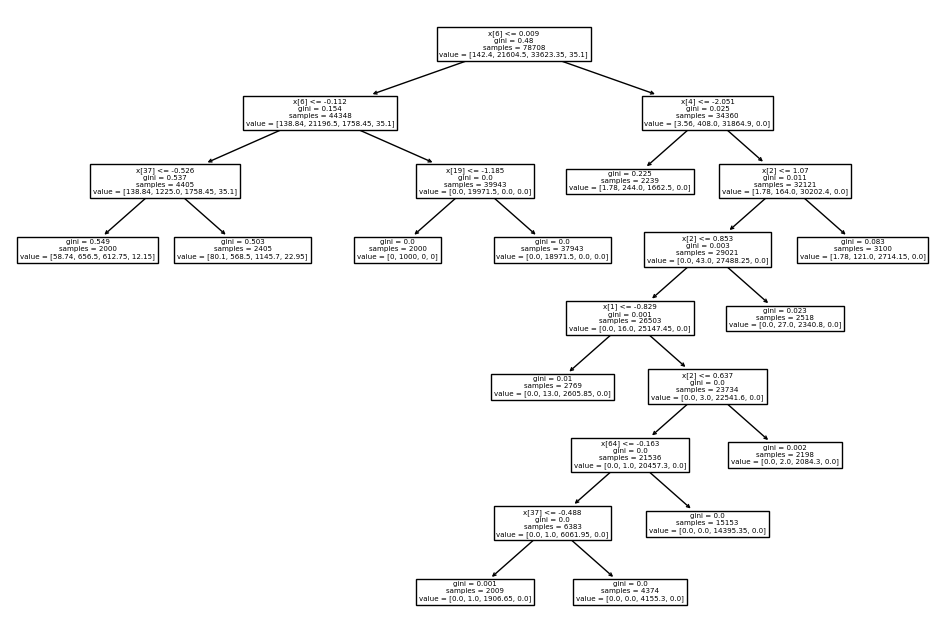

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree, ax=ax)

In [90]:
y_train_pred = tree.predict(X=x_train)
y_test_pred = tree.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.9656451694872186
test=0.9651895517837179


Результаты: 
1) Desision tree дает достаточно хорошее пресказание, примерно 0.8 на датасете из $10^6$ элементов. Однако совершенно не угадывает Severity=4
2) Если поэкспериментировать с количеством листов и максимальной глубиной, то можно улучшить результат. Но все равно Severity=4 не угадывается.
3) Изменение с gini на entropy также не изменяет ситуацию
4) при увеличении датасета, начинает угадывать 4, однако перестает 1
5) при max_depth=10, min_samples_leaf=500, criterion='gini' начал угадывать все 4 позиции, при этом доля правильно угаданных приблизительно 0.89
6) Результат получается немного лучше, если поиграться с весами

### Random Forest

In [91]:
random_forest = RandomForestClassifier(n_estimators=10,
                                       max_depth=12,
                                       min_samples_leaf=2000,
                                       criterion="gini",
                                       class_weight=class_weight,
                                       random_state=0,
                                       )
random_forest.fit(X=x_train, y=y_train)

RandomForestClassifier(class_weight={1: 1.78, 2: 0.5, 3: 0.95, 4: 1.35},
                       max_depth=12, min_samples_leaf=2000, n_estimators=10,
                       random_state=0)

In [92]:
y_train_pred = random_forest.predict(X=x_train)
y_test_pred = random_forest.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.9586827260253087
test=0.9454721008232544


Результаты: <br/>
Desision Tree работает лучше, связано это, скорее всего, с тем, что сильно много 2 и 3. Random Forest берет определенные части, при этом еще и пытается использовать различные признаки. В этих частях 2 и 3 слишком много и все сваливается в них.

### Bagging

In [93]:
bagging = BaggingClassifier(n_estimators=50,
                            max_samples=0.8,
                            max_features=0.9,
                            random_state=0,
                            estimator=DecisionTreeClassifier(max_depth=12,
                                                             min_samples_leaf=2000,
                                                             criterion='gini',
                                                             random_state=0
                                                             )
                            )
bagging.fit(X=x_train, y=y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12,
                                                   min_samples_leaf=2000,
                                                   random_state=0),
                  max_features=0.9, max_samples=0.8, n_estimators=50,
                  random_state=0)

In [94]:
y_train_pred = bagging.predict(X=x_train)
y_test_pred = bagging.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.9647685114600802
test=0.965596097164346


Результаты:
1) При использовании Bagging с DesisionTreeClassifier и с n_estimators=3, max_samples=0.8, max_features=0.9 результат демонстрируется очень хороший. На $10^5$ около 0.97. При этом угадывает все типы Severity
2) При более большом датасете модель достаточно сильно переобучается. Изменение параметров особо не помогают изменить ситуацию
3) при использовании estimator=DessisionTreeClassifier на всем датасете переобучения не возникает, при этом доля угаданных 0.89. Однако, стоит заметить что 1 и 4 угадывается не очень хорошо

### SVM

In [95]:
svm = SVC(kernel="sigmoid",
          max_iter=8000,
          random_state=0
          )
svm.fit(X=x_train, y=y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=8000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='sigmoid', max_iter=8000, random_state=0)

In [96]:
y_train_pred = svm.predict(X=x_train)
y_test_pred = svm.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

Результаты:
1) SVM с линейным ядром не эффективен. Угадывание: 0.54
2) SVM с полиномиальным ядром не эффективен. Угадывание: 0.44. Изменение степени полинома не помогает улучшить ситуацию
3) SVM c радиально базовой функцией не эффективен. Угадывание: 0.47
4) SVM c сигмоидой не эффективен. Угадывание: 0.57

### Logistic Regression

In [ ]:
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
logistic_regression.fit(X=x_train, y=y_train)

c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, multi_class='multinomial')

In [ ]:
y_train_pred = logistic_regression.predict(X=x_train)
y_test_pred = logistic_regression.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.6410275956700716
test=0.6367517024087814


In [ ]:
class BinLogisticClassifier(BaseEstimator):
    def __init__(self, classes: list | None = None) -> None:
        super().__init__()
        self.classes_ = classes
        self._Regressors = [
            LogisticRegression(multi_class="auto", solver="lbfgs"), # x_1, x_2 | x_3, x_4
            LogisticRegression(multi_class="auto", solver="lbfgs"), # x_1 | x_2
            LogisticRegression(multi_class="auto", solver="lbfgs") # x_3 | x_4
        ]
        
    def fit(self, X: NDArray, y: NDArray) -> None:
        train_classes = set(y)
        if self.classes_ == None:
            self.classes_ = list(train_classes)
        elif not self.classes_ == train_classes:
            ValueError("Not all classes were passed during initialization") 
        
        first_cls, second_cls = self.classes_[:2], self.classes_[2:]
        
        y_train_bin = [
            0 if cls in first_cls else 1
            for cls in y 
            ]
        
        self._Regressors[0].fit(X=X, y=y_train_bin)
        
        mask = y.isin(first_cls)
        
        first_X = X.loc[mask]
        second_X = X.loc[~mask]
        
        first_y_train_bin = pd.Series([
            0 if cls == first_cls[0] else 1
            for cls in y.loc[mask]
        ])
        second_y_train_bin = pd.Series([
            0 if cls == second_cls[0] else 1
            for cls in y.loc[~mask]
        ])
        
        self._fit(X=first_X, y=first_y_train_bin, bin_cls=0)
        self._fit(X=second_X, y=second_y_train_bin, bin_cls=1)
        
    def _fit(self, X: pd.DataFrame, y: pd.Series, bin_cls: int) -> None:
        self._Regressors[1 + bin_cls].fit(X=X, y=y)
        
    def predict(self, X: NDArray) -> NDArray:
        y_bin = self._Regressors[0].predict(X=X)
        mask = y_bin == 0
        
        first_X = X.loc[mask]
        second_X = X.loc[~mask]
                
        y_bins = [None, None]
        y_bins[0] = self._predict(first_X, 0)
        y_bins[1] = self._predict(second_X, 1)
        
        k = [-1, -1]
        encoded_classes = list()
        
        for cls in y_bin:
            k[cls] += 1
            encoded_classes.append((cls, y_bins[cls][k[cls]]))
            
        return np.array([
            self._decode(cls) for cls in encoded_classes
        ])
            
    def _predict(self, X: pd.DataFrame, bin_cls: int) -> NDArray:
        return self._Regressors[1 + bin_cls].predict(X=X)
    
    def _decode(self, code: tuple):
        code_book = {
            (0, 0): self.classes_[0],
            (0, 1): self.classes_[1],
            (1, 0): self.classes_[2],
            (1, 1): self.classes_[3]
        }
        return code_book[code]
    

In [ ]:
bin_logistic_regression = BinLogisticClassifier([1, 4, 2, 3])
bin_logistic_regression.fit(X=x_train, y=y_train)

c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
y_train_pred = bin_logistic_regression.predict(X=x_train)
y_test_pred = bin_logistic_regression.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

ValueError: Found array with 0 sample(s) (shape=(0, 72)) while a minimum of 1 is required by LogisticRegression.

In [ ]:
class LogisticRegressionReductingClassifier(BaseEstimator):
    def __init__(self, classes: list | None = None) -> None:
        super().__init__()
        self.classes_ = classes
        self._Regressors = [
            LogisticRegression(multi_class="auto", solver="lbfgs"), # x_1, x_2, x_3 | x_4
            LogisticRegression(multi_class="auto", solver="lbfgs"), # x_1,  x_2 | x_3
            LogisticRegression(multi_class="auto", solver="lbfgs") # x_1 | x_2
        ]
        
    def fit(self, X: NDArray, y: NDArray) -> None:
        train_classes = set(y)
        if self.classes_ == None:
            self.classes_ = list(train_classes)
        elif not self.classes_ == train_classes:
            ValueError("Not all classes were passed during initialization") 
            
        for i in range(len(self._Regressors)):
            classes = self.classes_[:len(self._Regressors) + 1 - i]
            mask = y.isin(classes)
            self._fit(X=X[mask], y=y[mask], n_regressor=i, classes=classes)
        
    def _fit(self, X: pd.DataFrame, y: pd.Series, n_regressor: int, classes: list) -> None:
        first_cls, second_cls = classes[:-1], classes[-1]
        
        y_train_bin = [
            0 if cls in first_cls else 1
            for cls in y 
            ]
        
        self._Regressors[n_regressor].fit(X=X, y=y_train_bin)
        
    def predict(self, X: pd.DataFrame) -> NDArray:
        
        y_predict = np.zeros(len(X), dtype=int)
        
        for i in range(len(self._Regressors)):
            y_bin = self._predict(X=X, n_regressor=i)
            mask = y_bin == 0
            X = X.loc[mask]
            k = 0
            for idx, y in enumerate(y_predict):
                if y == 0:
                    if y_bin[k] == 1:
                        y_predict[idx] = self.classes_[-(i + 1)]
                    k += 1
                    
            if len(X) == 0: 
                return y_predict
            
        return y_predict
            
            
    def _predict(self, X: pd.DataFrame, n_regressor: int) -> NDArray:
        return self._Regressors[n_regressor].predict(X=X)
    

In [ ]:
logistic_regression_reducting = LogisticRegressionReductingClassifier([1, 2, 3, 4])
logistic_regression_reducting.fit(X=x_train, y=y_train)

c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kolos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
y_train_pred = logistic_regression_reducting.predict(X=x_train)
y_test_pred = logistic_regression_reducting.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.6409005437820806
test=0.6367517024087814


Результаты:
1) На большом датасете логисчтическая регрессия дает достатточно хороший результат, около 0.8
2) если брать достаточно большой датасет, то проблема в том, что при первой регрессии склоняется ну тада, из-за чего начинаются проблемы и редко угадывает 1 и 4
3) модификации сильно не помогают в исправлении ситуации

### Naive Bassian Classifier

In [ ]:
bassian = GaussianNB()
bassian.fit(X=x_train, y=y_train)

GaussianNB()

In [ ]:
y_train_pred = bassian.predict(X=x_train)
y_test_pred = bassian.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.021878335112059766
test=0.5520378087203984


Результаты: <br/>
Все плохо, так как данные не сбалансированы. + не стоит забывать о том, что предполагается, что данные не коррелируют. У нас немного не так

### Linear Discriminant Analysis

In [ ]:
discriminant_analyse = LinearDiscriminantAnalysis(solver='lsqr')
discriminant_analyse.fit(X=x_train, y=y_train)

LinearDiscriminantAnalysis(solver='lsqr')

In [ ]:
y_train_pred = discriminant_analyse.predict(X=x_train)
y_test_pred = discriminant_analyse.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.634331961172943
test=0.6275027949994918


Результаты: <br/>
Аналогичные проблемы как с Logistic Regression

### Gradient Boosting

In [ ]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X=x_train, y=y_train)

GradientBoostingClassifier()

In [ ]:
y_train_pred = gradient_boosting.predict(X=x_train)
y_test_pred = gradient_boosting.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.9862402805305687
test=0.9774367313751398


In [ ]:
hist_gradient_boosting = HistGradientBoostingClassifier(loss='log_loss',
                                                        max_iter=500,
                                                        max_leaf_nodes=1000,
                                                        min_samples_leaf=800,
                                                        max_depth=10,
                                                        l2_regularization=10**(-1),
                                                        tol=10**(-7),
                                                        class_weight=None,
                                                        random_state=0
                                                        )
hist_gradient_boosting.fit(X=x_train, y=y_train)

HistGradientBoostingClassifier(l2_regularization=0.1, max_depth=10,
                               max_iter=500, max_leaf_nodes=1000,
                               min_samples_leaf=800, random_state=0)

In [ ]:
y_train_pred = hist_gradient_boosting.predict(X=x_train)
y_test_pred = hist_gradient_boosting.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )

train=0.9968618183666209
test=0.9799776400040655


Результаты:
1) Обычный градиентный бустинг работает очень долго. На $10^5$ около $1.5$ минуты
2) Работает очень хорошо, однако переобучается (оба, с hist даже сильнее)
3) немного подкрутив параметры можно немного улучшить результат и снизить переобучение
4) Попытка поработать с весами не дает серьезных улучшений
5) Работает гораздо дольше, чем деревья решений на всем датасете (около 34 минут, предсказания около 7 минут)
6) В целом, результат лучше примерно на 0.05. Однако стоит заметить, что 1 и 4 класс аварий определяются значительно лучше

In [ ]:
count_predicted_Severity = dict.fromkeys([1, 2, 3, 4], 0)
count_real_Severity = dict.fromkeys([1, 2, 3, 4], 0)

for p, r in zip(y_test_pred, y_test):
    count_real_Severity[r] += 1
    count_predicted_Severity[p] += 1
    
count_real_Severity, count_predicted_Severity

({1: 16, 2: 10864, 3: 8791, 4: 7}, {1: 13, 2: 10774, 3: 8888, 4: 3})

### Выводы:
1) лучшие модели для нашей задачи: 1.Gradient Boosting, 2.Bagging, 3.Desision Tree
2) Desision Tree значительно превосхоит по времени других алгоритмов, при этом точность не сильно ниже
3) KNN показывает не очень хорошие рещультаты, к тому же работает достаточно долго
4) SVM плохо применим из-за того, что данные имеют достаточно сложную структуру
5) Баесовских классификатор не дает хорошего результата из-за того, что между данные есть определенная классификация и они абсолютно не сбалансированы
6) Логисчитеская регрессия и дискриминантный анализ показывают хорошие результаты, но плохо определяют 1 и 4. Модификации логистической регрессии слабо исправляют ситуацию
7) Идеальной моделю по времени и точности является Bagging с Desision Tree